# Calculating tide statistics and satellite biases

This guide demonstrates how to use the `tidal_stats` function from the `eo_tides.stats` module to calculate statistics describing local tide dynamics, and identify biases caused by interactions between tidal processes and satellite orbits.

Complex interactions between temporal tide dynamics and the regular mid-morning overpass timing of sun-synchronous sensors like Landsat or Sentinel-2 mean that satellites often does not observe the entire tidal cycle. 
Biases in satellite coverage of the tidal cycle can mean that tidal extremes (e.g. the lowest or highest tides at a location) may either never be captured by satellites, or be over-represented in the satellite EO record. 
Local tide dynamics can cause these biases to vary greatly both through time and spatially (Figure 1), making it challenging to consistently analyse and compare coastal processes consistently - particularly for large-scale (e.g. regional or global) analyses.

To ensure that coastal EO analyses are not inadvertently affected by tide biases, it is important to compare how well the tides observed by satellites match the full range of tides at a location.
The `tidal_stats` function compares the subset of tides observed by satellite data against the full range of tides modelled at a regular interval through time (every two hours by default) across the entire time period covered by the satellite dataset.
This comparison is used to calculate several useful statistics and plots that summarise how well your satellite data capture real-world tidal conditions.

> **Figure 1:** Example of tide biases in Landsat satellite data across coastal Australia ([Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3)). "Spread" represents the proportion of the astronomical tide range observed by satellites; low and high tide "offsets" represent the proportion of highest and lowest tides never observed.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0272771418308783-gr8_lrg.jpg" alt="Tide bias figure">

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed discussion of the issue of tidal bias in sun-synchronous satellite observations of the coastline, refer to the 'Limitations and future work' section in <a href="https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3">Bishop-Taylor et al. 2018.</a>
    </p>
</div>

## Load Sentinel-2 satellite data using odc-stac

As in the previous example, we will first load a time-series of satellite data over our area of interest using the Open Data Cube's `odc-stac` package. 
In this example, we will load **Sentinel-2A and Sentinel 2B** satellite data from **2021-2023** over the city of **Broome, Western Australia**.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed guide to using STAC metadata and <code>odc-stac</code> to find and load satellite data, refer to the <a href="https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/">Digital Earth Australia STAC user guide</a>.
    </p>
</div>



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import odc.stac
import pystac_client

# Connect to STAC catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s2 = odc.stac.load(
    items=list(query.items()),
    bands=["nbart_red"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s2)

<xarray.Dataset> Size: 114MB
Dimensions:      (y: 371, x: 356, time: 216)
Coordinates:
  * y            (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x            (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 2kB 2021-01-03T02:12:28.232361 ... 202...
Data variables:
    nbart_red    (time, y, x) float32 114MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


## Using tide_stats

Using tide modelling location: 122.21, -18.00
Modelling tides using EOT20
Modelling tides using EOT20


🌊 Modelled astronomical tide range: 9.81 metres.
🛰️ Observed tide range: 6.37 metres.

    🔴 65% of the modelled astronomical tide range was observed at this location.
    🟢 The highest 8% (0.79 metres) of the tide range was never observed.
    🔴 The lowest 27% (2.64 metres) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 metres.
🛰️ Mean observed tide height: 0.76 metres.

    ⬆️ The mean observed tide height was 0.76 metres higher than the mean modelled astronomical tide height.


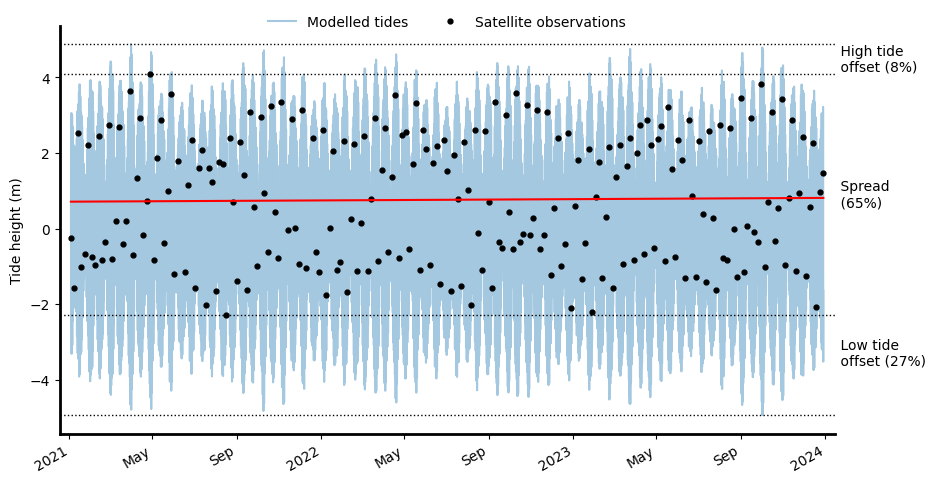

In [3]:
from eo_tides.stats import tide_stats

statistics_df = tide_stats(
    ds_s2,
    directory="../../tests/data/tide_models",
)


In [4]:
statistics_df

tidepost_lat        -18.000
tidepost_lon        122.210
observed_mean_m       0.761
all_mean_m           -0.000
observed_min_m       -2.287
all_min_m            -4.931
observed_max_m        4.084
all_max_m             4.876
observed_range_m      6.371
all_range_m           9.808
spread                0.650
low_tide_offset       0.270
high_tide_offset      0.081
dtype: float64

## Compare against Sentinel-1 tide biases

In [5]:
import planetary_computer

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-1-rtc"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s1 = odc.stac.load(
    items=list(query.items()),
    bands=["vv"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s1)

<xarray.Dataset> Size: 47MB
Dimensions:      (y: 371, x: 356, time: 89)
Coordinates:
  * y            (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x            (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 712B 2021-01-07T21:23:20.996123 ... 20...
Data variables:
    vv           (time, y, x) float32 47MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


Using tide modelling location: 122.21, -18.00
Modelling tides using EOT20
Modelling tides using EOT20


🌊 Modelled astronomical tide range: 9.55 metres.
🛰️ Observed tide range: 6.40 metres.

    🔴 67% of the modelled astronomical tide range was observed at this location.
    🔴 The highest 28% (2.72 metres) of the tide range was never observed.
    🟢 The lowest 4% (0.43 metres) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 metres.
🛰️ Mean observed tide height: -1.31 metres.

    ⬇️ The mean observed tide height was -1.31 metres lower than the mean modelled astronomical tide height.


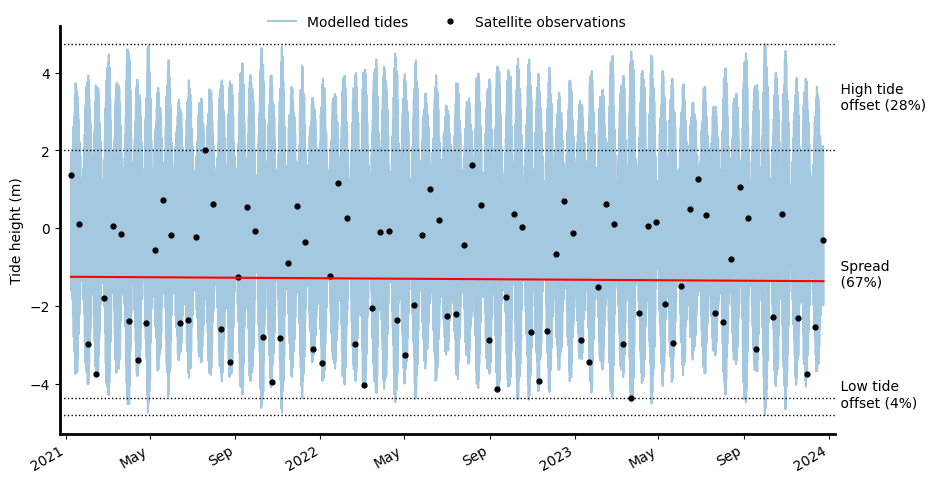

In [6]:
statistics_df = tide_stats(
    ds_s1,
    directory="../../tests/data/tide_models",
)


## Calculate biases for multiple satellite sensors

In [7]:
import xarray as xr

# Give each observation a "satellite_name" based on its satellite
ds_s1 = ds_s1.assign_coords(satellite_name=("time", ["Sentinel-1"] * ds_s1.sizes["time"]))
ds_s2 = ds_s2.assign_coords(satellite_name=("time", ["Sentinel-2"] * ds_s2.sizes["time"]))

# Combine both Sentinel-1 and Sentinel-2 data into a single dataset
ds_all = xr.concat([ds_s1, ds_s2], dim="time")
print(ds_all)


<xarray.Dataset> Size: 322MB
Dimensions:         (time: 305, y: 371, x: 356)
Coordinates:
  * y               (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x               (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref     int32 4B 32751
  * time            (time) datetime64[ns] 2kB 2021-01-07T21:23:20.996123 ... ...
    satellite_name  (time) <U10 12kB 'Sentinel-1' 'Sentinel-1' ... 'Sentinel-2'
Data variables:
    vv              (time, y, x) float32 161MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>
    tide_height     (time) float32 1kB 1.366 0.09767 -2.97 ... 0.9723 1.482
    nbart_red       (time, y, x) float32 161MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


Using tide modelling location: 122.21, -18.00
Modelling tides using EOT20
Modelling tides using EOT20


🌊 Modelled astronomical tide range: 9.81 metres.
🛰️ Observed tide range: 8.47 metres.

    🟡 86% of the modelled astronomical tide range was observed at this location.
    🟢 The highest 8% (0.79 metres) of the tide range was never observed.
    🟢 The lowest 6% (0.55 metres) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 metres.
🛰️ Mean observed tide height: 0.16 metres.

    ⬆️ The mean observed tide height was 0.16 metres higher than the mean modelled astronomical tide height.


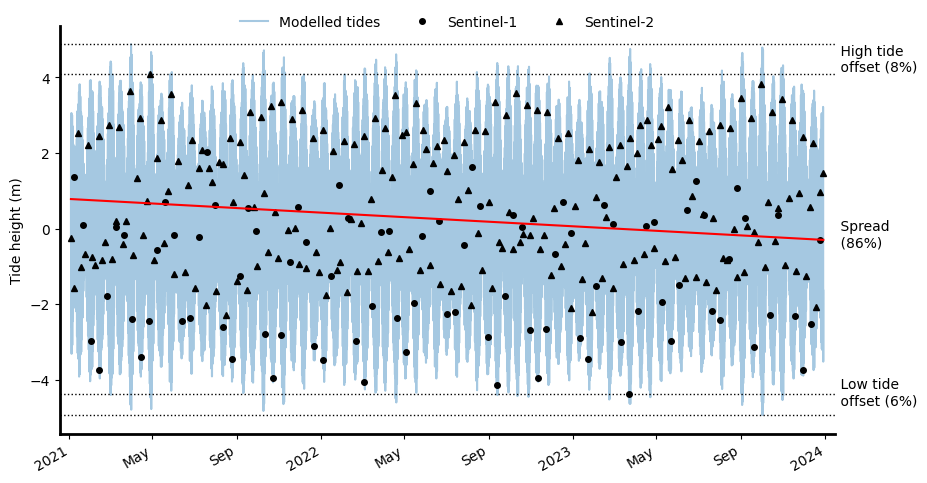

In [9]:
from eo_tides import tide_stats

statistics_df = tide_stats(
    ds_all,
    plot_col="satellite_name",
    directory="../../tests/data/tide_models",
)
